In [2]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



from sklearn import ensemble, metrics, model_selection
import os



from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
#!pip install transformers
import transformers
from transformers import BertTokenizer,AutoTokenizer, TFAutoModel,BertForSequenceClassification 
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AdamW

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import copy
from sklearn.model_selection import train_test_split

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
train_data = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test_data = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

**Enabling and testing the TPU:**

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

**Modelling:**

**XLM-RoBERTa:**

XLM means Cross-lingual Language Model. XLM-RoBERTa (XLM-R) is a pre-trained multilingual model that outperforms multiligual BERT. One reason for this is that XLM-R was trained using a lot more data. XLM-R was also trained on 100 languages.

Several versions of xlm roberta are available in the Transformers library. Here are two:

* xlm-roberta-base

* xlm-roberta-large

    XLM-RoBERTa uses a SentencePiece-based tokenizer but BERT does not.

    This is the link to the XLM-RoBERTa paper: https://arxiv.org/pdf/1911.02116.pdf

    Reference: [https://www.kaggle.com/vbookshelf/basics-of-bert-and-xlm-roberta-pytorch]


**XLM-RoBERTa Model: (Large)**

Parameters:

In [5]:
#L_RATE = 1e-5
 
#Epochs_Num = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
step = len(train_data) // BATCH_SIZE

Build The Model:

In [6]:
def model_defination(strategy,transformer):
    with strategy.scope():
        transformer_encoder = TFAutoModel.from_pretrained(transformer)
        input_layer = Input(shape=(30,), dtype=tf.int32, name="input_layer")
        sequence_output = transformer_encoder(input_layer)[0]
        cls_token = sequence_output[:, 0, :]
        output_layer = Dense(3, activation='softmax')(cls_token)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(
            Adam(lr=1e-5), 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

In [7]:
model=model_defination(strategy,"jplu/tf-xlm-roberta-large")

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 30, 1024), (None, 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 559,893,507
Trainable params: 559,893,507
Non-trainable params: 0
_________________________________________________________________


Tokenizing: With (xlm-roberta-large)

In [9]:
tokenizer = AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-large')

In [10]:
train_set1 = train_data[['premise','hypothesis']].values.tolist()
test_set1 = test_data[['premise','hypothesis']].values.tolist()

Encoding the Data:

In [11]:
encoded_train1 = tokenizer.batch_encode_plus(train_set1, pad_to_max_length=True, max_length=30)
encoded_test1 = tokenizer.batch_encode_plus(test_set1, pad_to_max_length=True, max_length=30)

In [12]:
train_data.premise.values[0]

'and these comments were considered in formulating the interim rules.'

In [13]:
print(encoded_train1.input_ids[0][0:14])

[0, 136, 6097, 24626, 3542, 90698, 23, 26168, 1916, 70, 1940, 464, 91736, 5]


In [15]:
train_data.hypothesis.values[0]

'The rules developed in the interim were put together with these comments in mind.'

In [16]:
print(encoded_train1.input_ids[0][14:32])

[2, 2, 581, 91736, 126809, 23, 70, 1940, 464, 3542, 3884, 25842, 678, 6097, 24626, 2]


In [17]:
encoded_train1.keys()

dict_keys(['input_ids', 'attention_mask'])

In [19]:
print(encoded_train1.attention_mask[0][0:35])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Train and Test Split:

In [20]:
X_train, X_valid, Y_train, Y_valid = train_test_split(encoded_train1['input_ids'], train_data.label.values, test_size=0.3)

x_test = encoded_test1['input_ids']

**Pipeline:**

In [21]:
train_df1 = (tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO))

valid_df1 = (tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(BATCH_SIZE).cache().prefetch(AUTO))

test_df1 = (tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE))

Training the Model:

In [22]:
#At epochs=3
history = model.fit(train_df1,steps_per_epoch=step,validation_data=valid_df1,epochs=3)

Epoch 1/3
94/94 [==============================] - 45s 478ms/step - loss: 1.1214 - accuracy: 0.3435 - val_loss: 1.0801 - val_accuracy: 0.3955
Epoch 2/3
94/94 [==============================] - 20s 214ms/step - loss: 1.0108 - accuracy: 0.4802 - val_loss: 0.8132 - val_accuracy: 0.6262
Epoch 3/3
94/94 [==============================] - 20s 214ms/step - loss: 0.7594 - accuracy: 0.6640 - val_loss: 0.7916 - val_accuracy: 0.6334


In [23]:
#At epochs=10
history1 = model.fit(train_df1,steps_per_epoch=step,validation_data=valid_df1,epochs=10)

Epoch 1/10
94/94 [==============================] - 21s 222ms/step - loss: 0.6122 - accuracy: 0.7396 - val_loss: 0.8344 - val_accuracy: 0.6733
Epoch 2/10
94/94 [==============================] - 20s 216ms/step - loss: 0.4950 - accuracy: 0.7940 - val_loss: 0.9385 - val_accuracy: 0.6570
Epoch 3/10
94/94 [==============================] - 20s 216ms/step - loss: 0.3737 - accuracy: 0.8481 - val_loss: 1.0954 - val_accuracy: 0.6664
Epoch 4/10
94/94 [==============================] - 20s 214ms/step - loss: 0.2622 - accuracy: 0.8958 - val_loss: 1.3519 - val_accuracy: 0.6579
Epoch 5/10
94/94 [==============================] - 20s 214ms/step - loss: 0.1995 - accuracy: 0.9246 - val_loss: 1.5059 - val_accuracy: 0.6664
Epoch 6/10
94/94 [==============================] - 20s 214ms/step - loss: 0.1327 - accuracy: 0.9505 - val_loss: 1.5734 - val_accuracy: 0.6634
Epoch 7/10
94/94 [==============================] - 20s 215ms/step - loss: 0.1106 - accuracy: 0.9584 - val_loss: 1.8309 - val_accuracy: 0.6617

**Visualizing:**

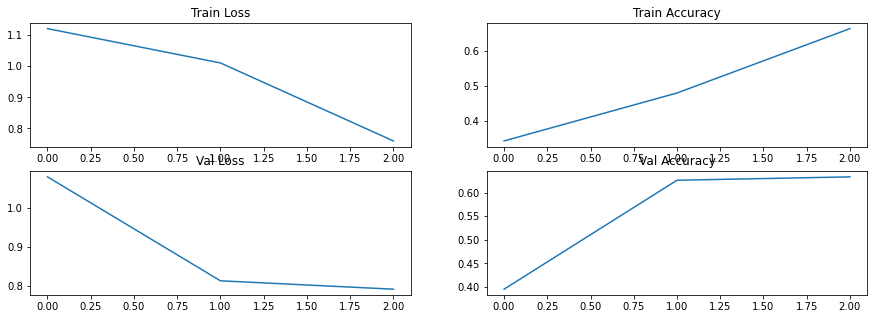

In [32]:
fig, ax = plt.subplots(2,  2, figsize=(15, 5))

ax[0,0].set_title('Train Loss')
ax[0,0].plot(history.history['loss'])


ax[0,1].set_title('Train Accuracy')
ax[0,1].plot(history.history['accuracy'])


ax[1,0].set_title('Val Loss')
ax[1,0].plot(history.history['val_loss'])


ax[1,1].set_title('Val Accuracy')
ax[1,1].plot(history.history['val_accuracy'])


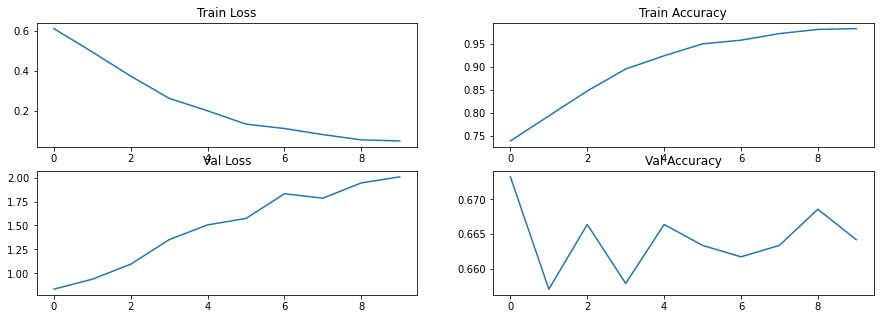

In [33]:
fig, ax = plt.subplots(2,  2, figsize=(15, 5))

ax[0,0].set_title('Train Loss')
ax[0,0].plot(history1.history['loss'])


ax[0,1].set_title('Train Accuracy')
ax[0,1].plot(history1.history['accuracy'])


ax[1,0].set_title('Val Loss')
ax[1,0].plot(history1.history['val_loss'])


ax[1,1].set_title('Val Accuracy')
ax[1,1].plot(history1.history['val_accuracy'])


**XLM-RoBERTa Model: (BASE)**

Parameters:

In [24]:
#Epochs_Num = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
step = len(train_data) // BATCH_SIZE

**Build the Model:**

In [25]:
def model_defination(strategy,transformer):
    with strategy.scope():
        transformer_encoder = TFAutoModel.from_pretrained(transformer)
        input_layer = Input(shape=(30,), dtype=tf.int32, name="input_layer")
        sequence_output = transformer_encoder(input_layer)[0]
        cls_token = sequence_output[:, 0, :]
        output_layer = Dense(3, activation='softmax')(cls_token)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(
            Adam(lr=1e-5), 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

In [26]:
model=model_defination(strategy,"jplu/tf-xlm-roberta-base")

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
tf_roberta_model_1 (TFRobert ((None, 30, 768), (None,  278043648 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 2307      
Total params: 278,045,955
Trainable params: 278,045,955
Non-trainable params: 0
_________________________________________________________________


**Tokenizing: With (xlm-roberta-base)**

In [28]:
tokenizer = AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-base')

In [29]:
train_set = train_data[['premise','hypothesis']].values.tolist()
test_set = test_data[['premise','hypothesis']].values.tolist()

**Encoding the Data:**

In [30]:
encoded_train = tokenizer.batch_encode_plus(train_set, pad_to_max_length=True, max_length=30)
encoded_test = tokenizer.batch_encode_plus(test_set, pad_to_max_length=True, max_length=30)

In [31]:
train_data.premise.values[0]

'and these comments were considered in formulating the interim rules.'

In [32]:
print(encoded_train.input_ids[0][0:14])

[0, 136, 6097, 24626, 3542, 90698, 23, 26168, 1916, 70, 1940, 464, 91736, 5]


In [33]:
train_data.hypothesis.values[0]

'The rules developed in the interim were put together with these comments in mind.'

In [34]:
print(encoded_train.input_ids[0][14:32])

[2, 2, 581, 91736, 126809, 23, 70, 1940, 464, 3542, 3884, 25842, 678, 6097, 24626, 2]


In [35]:
encoded_train.keys()

dict_keys(['input_ids', 'attention_mask'])

In [36]:
print(encoded_train.attention_mask[0][0:35])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


**Train and Test Split:**

In [37]:
X_train, X_valid, Y_train, Y_valid = train_test_split(encoded_train['input_ids'], train_data.label.values, test_size=0.3)

x_test = encoded_test['input_ids']

**Pipeline:**

In [38]:
train_df = (tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO))

valid_df = (tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(BATCH_SIZE).cache().prefetch(AUTO))

test_df = (tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE))

**Training the Model:**

In [39]:
#Epochs=3
history = model.fit(train_df,steps_per_epoch=step,validation_data=valid_df,epochs=3)

Epoch 1/3
94/94 [==============================] - 22s 238ms/step - loss: 1.2088 - accuracy: 0.3393 - val_loss: 1.0948 - val_accuracy: 0.3790
Epoch 2/3
94/94 [==============================] - 10s 109ms/step - loss: 1.1056 - accuracy: 0.4113 - val_loss: 1.0327 - val_accuracy: 0.4774
Epoch 3/3
94/94 [==============================] - 10s 111ms/step - loss: 1.0132 - accuracy: 0.4926 - val_loss: 0.9287 - val_accuracy: 0.5688


In [40]:
#Epochs=10
history1 = model.fit(train_df,steps_per_epoch=step,validation_data=valid_df,epochs=10)

Epoch 1/10
94/94 [==============================] - 10s 106ms/step - loss: 0.9125 - accuracy: 0.5722 - val_loss: 0.9117 - val_accuracy: 0.5817
Epoch 2/10
94/94 [==============================] - 10s 109ms/step - loss: 0.8224 - accuracy: 0.6286 - val_loss: 0.9251 - val_accuracy: 0.5894
Epoch 3/10
94/94 [==============================] - 10s 110ms/step - loss: 0.7205 - accuracy: 0.6892 - val_loss: 1.0449 - val_accuracy: 0.5996
Epoch 4/10
94/94 [==============================] - 10s 109ms/step - loss: 0.6316 - accuracy: 0.7307 - val_loss: 1.0663 - val_accuracy: 0.6018
Epoch 5/10
94/94 [==============================] - 10s 111ms/step - loss: 0.5190 - accuracy: 0.7854 - val_loss: 1.1402 - val_accuracy: 0.5954
Epoch 6/10
94/94 [==============================] - 10s 110ms/step - loss: 0.4206 - accuracy: 0.8336 - val_loss: 1.3143 - val_accuracy: 0.5943
Epoch 7/10
94/94 [==============================] - 11s 112ms/step - loss: 0.3309 - accuracy: 0.8704 - val_loss: 1.6559 - val_accuracy: 0.5776

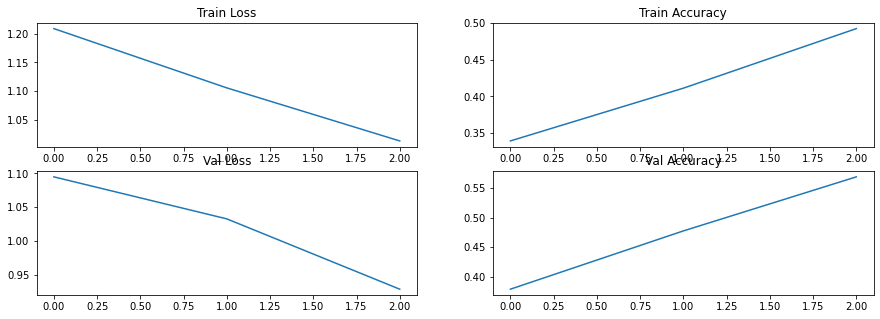

In [41]:
fig, ax = plt.subplots(2,  2, figsize=(15, 5))

ax[0,0].set_title('Train Loss')
ax[0,0].plot(history.history['loss'])


ax[0,1].set_title('Train Accuracy')
ax[0,1].plot(history.history['accuracy'])


ax[1,0].set_title('Val Loss')
ax[1,0].plot(history.history['val_loss'])


ax[1,1].set_title('Val Accuracy')
ax[1,1].plot(history.history['val_accuracy'])

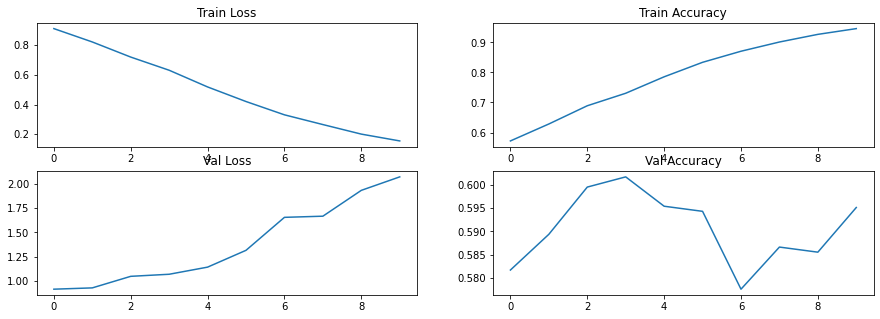

In [42]:
fig, ax = plt.subplots(2,  2, figsize=(15, 5))

ax[0,0].set_title('Train Loss')
ax[0,0].plot(history1.history['loss'])


ax[0,1].set_title('Train Accuracy')
ax[0,1].plot(history1.history['accuracy'])


ax[1,0].set_title('Val Loss')
ax[1,0].plot(history1.history['val_loss'])


ax[1,1].set_title('Val Accuracy')
ax[1,1].plot(history1.history['val_accuracy'])